TODO:
- better exit criteria than fixed time
- purchasing power seems very spikey/seasonal, we need to stabilize it or only play under right circumstances (VIX?)
- Try 5m, lots of the patterns were cleaner there (execution on 1m still)

- PSAR is too sensitive to differing data, can wipe out the strategy 
    - try abs(PSAR-close) > threshold instead of abs(PSAR-close) > 0
    - try dPSAR/dt (change in PSAR is strong)
    - multiple PSARs must agree?
- PSAR lookback is too sensitive to minor reversions
- ADX threshold is super sensitive too, do we scale qty? (18->0, 20->100% of target qty, scale linearly)
- CCI threshold is also sensitive

- check end time period; 11:30 vs 11:32

- Try DI?
- Backtrader keep intentions

- over 200ema (on daily chart) -> call, under -> put
- day is positive -> call, day is negative -> put
- broader market?

In [1]:
%%capture
import sys; sys.path.append('../../..')

# Requires alpaca_trade_api backtrader matplotlib==3.2.2 plotly quantstats ta-lib (also requires talib C install)
from alpaca_trade_api.rest import REST, TimeFrame
import backtrader as bt
import matplotlib as mpl
import pytz
import datetime
from functools import lru_cache

import datetime

mpl.rcParams['figure.dpi'] = 250


API_KEY: str = ""
SECRET_KEY: str = ""
for l in open('../../../paper.env'):
    if l.startswith("APCA_API_KEY_ID="):
        API_KEY = l.split("=")[1].strip()
    elif l.startswith("APCA_API_SECRET_KEY="):
        SECRET_KEY = l.split("=")[1].strip()

assert API_KEY
assert SECRET_KEY

rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')



@lru_cache()
def get_pandas_data(symbol, timeframe, start, end):
  alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
  alpaca_data.index = alpaca_data.index.tz_convert("America/New_York")

  if timeframe != TimeFrame.Day:
    alpaca_data = alpaca_data.between_time(datetime.time(9, 30), datetime.time(16, 0), include_end=False)

  return alpaca_data


def run_backtest(strategy, symbol: str, start: datetime.date, end: datetime.date, params, cash: float):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.addstrategy(strategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

  data1m = get_pandas_data(symbol, TimeFrame.Minute, start, end)
  feed1 = bt.feeds.PandasData(dataname=data1m, name=f"{symbol}-1m", tz=pytz.timezone('US/Eastern'))
  cerebro.adddata(feed1)

  # NOTE: -31 days so we have room for daily indicator warmup period for indicators
  # datad = get_pandas_data(symbol, TimeFrame.Day, start - datetime.timedelta(days=31), end)
  # feed2 = bt.feeds.PandasData(dataname=datad, name=f"{symbol}-d", tz=pytz.timezone('US/Eastern'))
  # cerebro.adddata(feed2)

  results = cerebro.run()

  cerebro.plot(iplot=True)

  strat = results[0]
  return strat

def get_roi(strategy):
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  r = 1
  for ret in annual_returns.values():
    r *= 1 + ret
  r -= 1
  return r

def get_max_drawdown(strategy):
  return strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100



In [2]:
symbol = 'AAPL'
start = datetime.date(2022, 1, 1)
end = datetime.date(2022, 7, 18)
cash = 750

In [3]:
FOR_ENTRY_AND_EXIT = "FOR_ENTRY_AND_EXIT"
FOR_ENTRY = "FOR_ENTRY"
NO = "NO"

class MyStrategy(bt.Strategy):
    params = dict(
        use_cci = FOR_ENTRY,
        cci_period = 20,
        cci_factor = 0.015,  # default, unconfirmed
        cci_upper = 100,
        cci_lower = -100,

        use_macd = FOR_ENTRY_AND_EXIT,
        macd_settings = (5, 21, 5),

        use_emacross = FOR_ENTRY,
        emas = (9, 20, 50),
        emas_cross_criteria_any_instead_of_all = True,
        emas_any_on_cross_instead_of_while_rightly_ordered = False,

        use_psar = FOR_ENTRY,
        psar_af = 0.018,
        psar_afmax = 0.2,
        psar_period = 2,

        use_psar_lookback = FOR_ENTRY,
        psar_lookback_period = 3,

        use_mfi = NO,
        mfi_period = 14,
        mfi_upper = 80,
        mfi_lower = 20,

        # Must be strong
        use_adx = FOR_ENTRY,
        adx_period = 14,
        adx_min_strength = 20,

        # Must be getting stronger
        use_adx_slope = FOR_ENTRY,
        adx_slope_smoothing_period = 5,

        # Indicate direction (better than PSAR, ideally)
        use_di = FOR_ENTRY,
        di_period = 14,

        use_long_ema = FOR_ENTRY,
        long_ema_period = 200,

        start_of_morning = datetime.time(9, 32),
        end_of_morning = datetime.time(11, 30),
        start_of_afternoon = datetime.time(14, 30),
        end_of_day = datetime.time(15, 58),  # issues order 1m after

        verbose=False,
    )

    def add_signal(self, should_use: bool, long_signal, short_signal):
      if should_use not in (FOR_ENTRY, FOR_ENTRY_AND_EXIT):
        return
      
      if should_use == FOR_ENTRY:
        self.buy_long_signals.append(long_signal)
        self.buy_short_signals.append(short_signal)
      elif should_use == FOR_ENTRY_AND_EXIT:
        self.stay_long_signals.append(long_signal)
        self.stay_short_signals.append(short_signal)

    def log(self, *message):
      if self.p.verbose:
        print(self.data.datetime.datetime(0), *message)


    def __init__(self):
        self.stay_long_signals = []
        self.buy_long_signals = []

        self.stay_short_signals = []
        self.buy_short_signals = []

        if self.p.use_psar != NO:
          self.log('Using PSAR')
          self.psar = bt.ind.PSAR(period=self.p.psar_period, af=self.p.psar_af, afmax=self.p.psar_afmax)
          self.add_signal(self.p.use_psar, self.psar.psar < self.data.close, self.psar.psar > self.data.close)
        
          if self.p.use_psar_lookback != NO:
            self.log('Using PSAR lookback')
            # PSAR signal should have been facing the other way 3m ago
            long_signal = self.psar.psar(-self.p.psar_lookback_period) > self.data.close(-self.p.psar_lookback_period)
            short_signal = self.psar.psar(-self.p.psar_lookback_period) < self.data.close(-self.p.psar_lookback_period)
            self.add_signal(self.p.use_psar_lookback, long_signal, short_signal)
        
        if self.p.use_adx != NO:
          self.log('Using ADX')
          self.adx = bt.ind.ADX(period=self.p.adx_period)
          self.add_signal(self.p.use_adx, self.adx > self.p.adx_min_strength, self.adx > self.p.adx_min_strength)
        
          if self.p.use_adx_slope != NO:
            self.log('Using ADX slope')
            self.add_signal(self.p.use_adx_slope, self.adx.adx(0) - self.adx.adx(-self.p.adx_slope_smoothing_period) > 0, self.adx.adx(0) - self.adx.adx(-self.p.adx_slope_smoothing_period) > 0)
        
        if self.p.use_di != NO:
          self.log('Using DI')
          self.di = bt.ind.DI(period=self.p.di_period)
          self.add_signal(self.p.use_di, self.di.plusDI > self.di.minusDI, self.di.plusDI < self.di.minusDI)

        if self.p.use_long_ema != NO:
          self.log('Using Long EMA')
          self.ema = bt.ind.EMA(period=self.p.long_ema_period)
          self.add_signal(self.p.use_long_ema, self.data.close > self.ema, self.data.close < self.ema)
 
        if self.p.use_emacross != NO:
          self.log('Using EMA Cross')
          ema_signals = []
          for ema_period in self.p.emas:
            signal = bt.ind.EMA(period=ema_period)
            setattr(self, f'ema_{ema_period}', signal)
            ema_signals.append(signal)

          if self.p.emas_cross_criteria_any_instead_of_all:
            long_signal = bt.Max(0, 1) > 1 # False
            short_signal = bt.Max(0, 1) > 1 # False
            for i in range(len(ema_signals) - 1):
              fast, slow = ema_signals[i], ema_signals[i + 1]

              if self.p.emas_any_on_cross_instead_of_while_rightly_ordered:
                # Whenever something crosses the right way
                long_signal = bt.Or(long_signal, bt.ind.CrossUp(fast, slow))
                short_signal = bt.Or(short_signal, bt.ind.CrossDown(fast, slow))
              else:
                # ANY must be in correct order
                long_signal = bt.Or(long_signal, fast > slow)
                short_signal = bt.Or(short_signal, fast < slow)

              
          else:
            # ALL must be in correct order
            long_signal = bt.Max(0, 1) > 0 # True
            short_signal = bt.Max(0, 1) > 0 # True
            for i in range(len(ema_signals) - 1):
              fast, slow = ema_signals[i], ema_signals[i + 1]
              # fastest > fast > ... > slow > slowest
              long_signal = bt.And(long_signal, fast > slow)
              # fastest < fast < ... < slow < slowest
              short_signal = bt.And(short_signal, fast < slow)
          
          self.add_signal(self.p.use_emacross, long_signal, short_signal)
        
        if self.p.use_macd != NO:
          self.log('Using MACD')
          period_me1, period_me2, period_signal = self.p.macd_settings
          self.macd = bt.ind.MACD(period_me1=period_me1, period_me2=period_me2, period_signal=period_signal)
          self.add_signal(self.p.use_macd, self.macd.macd > self.macd.signal, self.macd.macd < self.macd.signal)
        
        if self.p.use_cci != NO:
          self.log('Using CCI')
          self.cci = bt.ind.CCI(period=self.p.cci_period, factor=self.p.cci_factor, upperband=self.p.cci_upper, lowerband=self.p.cci_lower)
          self.add_signal(self.p.use_cci, self.cci.cci > self.p.cci_upper, self.cci.cci < self.p.cci_lower)
        
        if self.p.use_mfi != NO:
          self.log('Using MFI')
          self.mfi = bt.talib.MFI(self.data.high, self.data.low, self.data.close, self.data.volume, timeperiod=self.p.mfi_period)
          self.add_signal(self.p.use_mfi, self.mfi > self.p.mfi_upper, self.mfi < self.p.mfi_lower)

        self.stay_long = bt.And(*self.stay_long_signals, bt.Max(0, 1) > 0)
        self.buy_long = bt.And(self.stay_long, *self.buy_long_signals)
        
        self.stay_short = bt.And(*self.stay_short_signals, bt.Max(0, 1) > 0)
        self.buy_short = bt.And(self.stay_short, *self.buy_short_signals)


    def next(self):
      now = self.data.datetime.time()

      if not (now >= self.p.start_of_morning and now <= self.p.end_of_morning) and not (now >= self.p.start_of_afternoon and now < self.p.end_of_day):
        self.order_target_size(target=0)
        return

      if self.position:
        if self.position.size > 0 and not self.stay_long:
          self.order_target_size(target=0)
        elif self.position.size < 0 and not self.stay_short:
          self.order_target_size(target=0)
      else:
        if self.buy_long:
          self.order_target_size(target=1)
        elif self.buy_short:
          self.order_target_size(target=-1)
        else:
          self.order_target_size(target=0)


# Detail

In [4]:
strategy = run_backtest(MyStrategy, symbol, start, end,
  {'use_cci': 'FOR_ENTRY', 'cci_period': 20, 'cci_factor': 0.015, 'cci_upper': -1000, 'cci_lower': -100, 'use_macd': 'FOR_ENTRY', 'macd_settings': (12, 26, 9), 'use_emacross': 'FOR_ENTRY', 'emas': (9, 20, 50, 200), 'emas_cross_criteria_any_instead_of_all': True, 'emas_any_on_cross_instead_of_while_rightly_ordered': False, 'use_psar': 'NO', 'psar_af': 0.021, 'psar_afmax': 0.2, 'psar_period': 2, 'use_psar_lookback': 'NO', 'psar_lookback_period': 3, 'use_mfi': 'NO', 'mfi_upper': 80, 'mfi_lower': 20, 'use_adx': 'FOR_ENTRY', 'adx_period': 14, 'adx_min_strength': 20, 'use_adx_slope': 'NO', 'adx_slope_smoothing_period': 5, 'use_di': 'FOR_ENTRY', 'di_period': 9, 'use_long_ema': 'NO', 'long_ema_period': 200, 'start_of_morning': datetime.time(9, 32), 'end_of_morning': datetime.time(11, 30), 'start_of_afternoon': datetime.time(14, 30), 'end_of_day': datetime.time(15, 58), 'verbose': True}
  , cash
)

2022-07-18 15:59:00 Using ADX
2022-07-18 15:59:00 Using DI
2022-07-18 15:59:00 Using EMA Cross
2022-07-18 15:59:00 Using MACD
2022-07-18 15:59:00 Using CCI


<IPython.core.display.Javascript object>

In [6]:
annual_returns = strategy.analyzers.annualreturn.get_analysis()
analysis = strategy.analyzers.tradeanalyzer.get_analysis()
print(strategy.p.__dict__)
print(f"ROI     : {get_roi(strategy):.1%}")
print(f"Drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100:.1%}")
print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")

{'use_cci': 'FOR_ENTRY', 'cci_period': 20, 'cci_factor': 0.015, 'cci_upper': -1000, 'cci_lower': -100, 'use_macd': 'FOR_ENTRY', 'macd_settings': (12, 26, 9), 'use_emacross': 'FOR_ENTRY', 'emas': (9, 20, 50, 200), 'emas_cross_criteria_any_instead_of_all': True, 'emas_any_on_cross_instead_of_while_rightly_ordered': False, 'use_psar': 'NO', 'psar_af': 0.021, 'psar_afmax': 0.2, 'psar_period': 2, 'use_psar_lookback': 'NO', 'psar_lookback_period': 3, 'use_mfi': 'NO', 'mfi_upper': 80, 'mfi_lower': 20, 'use_adx': 'FOR_ENTRY', 'adx_period': 14, 'adx_min_strength': 20, 'use_adx_slope': 'NO', 'adx_slope_smoothing_period': 5, 'use_di': 'FOR_ENTRY', 'di_period': 9, 'use_long_ema': 'NO', 'long_ema_period': 200, 'start_of_morning': datetime.time(9, 32), 'end_of_morning': datetime.time(11, 30), 'start_of_afternoon': datetime.time(14, 30), 'end_of_day': datetime.time(15, 58), 'verbose': True}
ROI     : 5.2%
Drawdown: 1.7%
Average : 268 trades @ 0.15
Winners : 53.7% @ 1.29
Losers  : 46.3% @ -1.18


                    Strategy
------------------  ----------
Start Period        2022-01-03
End Period          2022-07-18
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   5.25%
CAGR﹪              10.0%

Sharpe              2.16
Sortino             3.51
Sortino/√2          2.48
Omega               1.4

Max Drawdown        -1.49%
Longest DD Days     47

Gain/Pain Ratio     0.4
Gain/Pain (1M)      2.55

Payoff Ratio        1.3
Profit Factor       1.4
Common Sense Ratio  1.79
CPC Index           0.95
Tail Ratio          1.28
Outlier Win Ratio   2.93
Outlier Loss Ratio  3.4

MTD                 -0.86%
3M                  2.37%
6M                  4.83%
YTD                 5.25%
1Y                  5.25%
3Y (ann.)           10.0%
5Y (ann.)           10.0%
10Y (ann.)          10.0%
All-time (ann.)     10.0%

Avg. Drawdown       -0.55%
Avg. Drawdown Days  10
Recovery Factor     3.52
Ulcer Index         0.01
Serenity Index      2.9


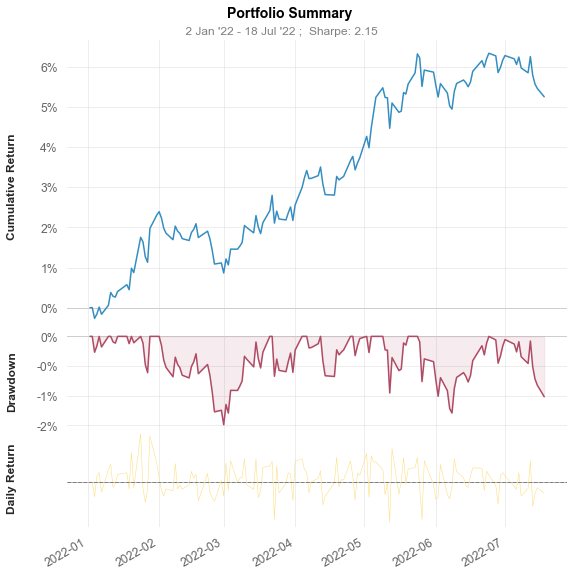

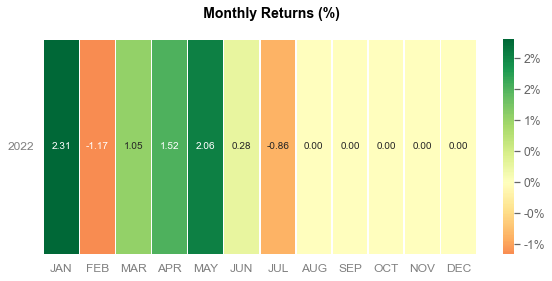

In [7]:
import quantstats
portfolio_stats = strategy.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
quantstats.reports.basic(returns)

In [ ]:
from src.results import metadata, from_backtest
from src import types

transactions.index = transactions.index.tz_convert("America/New_York")
transactions['time'] = transactions.index

from_backtest.write_results("Apples", [types.FilledOrder(intention=None,
    symbol=t['symbol'].split('-')[0],  # because datasource is 'AAPL-1m', gotta remove the '-1m'
    quantity=t['amount'], price=t['price'], datetime=t['time'].to_pydatetime()) for t in transactions.to_dict('records')], metadata.Metadata(commit_id="", last_updated=datetime.datetime.now()))

# Optimize

In [ ]:
gridsearch = dict(
    use_cci = [FOR_ENTRY], # NO = both upper and lower ignore
    cci_period = [20],
    cci_factor = [0.015],
    cci_upper = [-1000],
    cci_lower = [-100],

    use_macd = [FOR_ENTRY],
    macd_settings = [
      (12, 26, 9),
    ],

    use_emacross = [FOR_ENTRY],
    emas = [
      (9, 20, 50, 200),
    ],
    emas_cross_criteria_any_instead_of_all = [True],
    emas_any_on_cross_instead_of_while_rightly_ordered = [False],

    use_psar = [NO, FOR_ENTRY],
    psar_af = [0.021],
    psar_afmax = [0.2],
    psar_period = [2],

    use_psar_lookback = [NO],
    psar_lookback_period = [3],  # 3 over 5, 7, 9

    use_mfi = [NO], # NO = both upper and lower ignore
    mfi_upper = [80], # 0=ignore
    mfi_lower = [20], # 100=ignore

    use_di = [FOR_ENTRY, NO],
    di_period = [5, 9, 14, 20, 30, 50],

    use_adx = [FOR_ENTRY],
    adx_period = [14],
    adx_min_strength = [20],

    # Must be getting stronger
    use_adx_slope = [NO],
    adx_slope_smoothing_period = [5],

    use_long_ema = [NO],
    long_ema_period = [200],

    start_of_morning =   [datetime.time( 9, 32)],
    end_of_morning =     [datetime.time(11, 30)],  # 11:30 over 11, 10:30, and 15:58
    start_of_afternoon = [datetime.time(14, 30)],
    end_of_day =         [datetime.time(15, 58)],  # issues order 1m after
)

time_per = datetime.timedelta(seconds=14)

choices = 1
for l in gridsearch.values():
  choices *= len(l)

estimated_time = time_per * choices
print(f"Estimated time (@ {time_per}, {choices}): {estimated_time}")
start_time = datetime.datetime.now()
print(f"(ending at {start_time + (time_per * choices)})")
print("=" * 80)

cerebro = bt.Cerebro(stdstats=True, maxcpus=1)  # inside of VS Code editor, this does not go well
cerebro.broker.setcash(cash)
cerebro.optstrategy(MyStrategy, **gridsearch)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")

data1m = get_pandas_data(symbol, TimeFrame.Minute, start, end)
feed1 = bt.feeds.PandasData(dataname=data1m, name=f"{symbol}-1m", tz=pytz.timezone('US/Eastern'))
cerebro.adddata(feed1)

# NOTE: -31 days so we have room for daily indicator warmup period for indicators
# datad = get_pandas_data(symbol, TimeFrame.Day, start - datetime.timedelta(days=31), end)
# feed2 = bt.feeds.PandasData(dataname=datad, name=f"{symbol}-d", tz=pytz.timezone('US/Eastern'))
# cerebro.adddata(feed2)

runs = cerebro.run()
backtest_results = [results[0] for results in runs]


end_time = datetime.datetime.now()
print(f"Done. Took {end_time - start_time}")
print(f"time per: {(end_time - start_time) / choices}")

In [ ]:
import pandas as pd

def build_row(strategy):
  analysis = strategy.analyzers.tradeanalyzer.get_analysis()
  row = {
    'roi': get_roi(strategy),
    'drawdown': get_max_drawdown(strategy),
    'trades': analysis['total']['total'],
    'average_$': analysis['pnl']['gross']['average'],
    'win_rate': analysis['won']['total'] / analysis['total']['total'],
    'average_win_$': analysis['won']['pnl']['average'],
    'average_loss_$': analysis['lost']['pnl']['average'],
    'params': strategy.p.__dict__
  }
  row.update(strategy.p.__dict__)
  return row
results = pd.DataFrame([build_row(strategy) for strategy in sorted(backtest_results, key=get_roi, reverse=True) if strategy.analyzers.tradeanalyzer.get_analysis()['total']['total'] > 0])

In [ ]:
results.sort_values('roi').tail()

In [ ]:
mpl.rcParams['figure.dpi'] = 150
results.plot(x='roi', y='drawdown', kind='scatter', xlim=(0, .2), ylim=(0, .05), title="Parameter Optimization")